# Planejamento da Solução (IOT)

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade "INSIDERS"
2. Conjunto de dados com as vendas de produtos durantes 1 ano (11/2015 - 12/2017)

## Output - Saída
 
1. A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".
2. Relatório com as respostas das perguntas de negocio.

## Tasks - Processo

# 0.0. Imports

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from umap.umap_ import UMAP
from IPython.display import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pandas_profiling import ProfileReport

from sklearn import cluster
from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import ensemble as en

## 0.1. Helper Functions

In [3]:
def descriptive_statistics(num_attr):
    # Central Tendency: mean, median
    c1 = pd.DataFrame(num_attr.apply(np.mean))
    c2 = pd.DataFrame(num_attr.apply(np.median))

    # Dispension: min, max, range, std, skew, kurtosis
    d1 = pd.DataFrame(num_attr.apply(min))
    d2 = pd.DataFrame(num_attr.apply(max))
    d3 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min()))
    d4 = pd.DataFrame(num_attr.apply(lambda x: x.std()))
    
    # Measures of Shape
    s1 = pd.DataFrame(num_attr.apply(lambda x: x.skew()))
    s2 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis()))

    # concat
    m = pd.concat([d1,d2,d3,c1,c2,d4,s1,s2], axis=1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Data

In [4]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimnesions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3. Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge 
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(['customer_id_x', 'customer_id_y'], axis=1)

In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [14]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7. Descriptive Statistics

In [15]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(include=['object'])

## 1.7.1. Numerical Attributes

In [16]:
descriptive_statistics(num_att)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.55,3.00,218.08,-0.26,119769.16
1,unit_price,-11062.06,38970.00,50032.06,4.61,2.08,96.76,186.51,59005.72
2,customer_id,12346.00,22709.00,10363.00,16688.84,16249.00,2911.41,0.49,-0.80


**Notes:**
    
1. quantity: numero negativo e alto, pode ser retorno
2. unit_price: zero unidades? 

## 1.7.2. Categorical Attributes

In [17]:
cat_att.describe(include=['O'])

,invoice_no,stock_code,description,country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


### invoice_no

In [18]:
list_letter_invoice = df1.loc[~df1['invoice_no'].apply(lambda x: bool(re.search(r'^[0-9]+', x))), 'invoice_no'].tolist()
len(list_letter_invoice)

9291

In [19]:
list_letter_invoice[:10]

['C536379',
 'C536383',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536506']

### stock_code

In [20]:
list_letter_stock_code = df1.loc[~df1['stock_code'].apply(lambda x: bool(re.search(r'[^a-zA-Z]+$', x))), 'stock_code'].tolist()

len(list_letter_stock_code)

54675

### country

In [21]:
df1['country'].value_counts(normalize=True).head(10)

United Kingdom   0.91
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.00
Netherlands      0.00
Belgium          0.00
Switzerland      0.00
Portugal         0.00
Australia        0.00
Name: country, dtype: float64

**Notes**
1. invoice_no: 8905 items que não são somente numeros.
2. stock_code: 35809 items que não são somente numeros.
3. description: não tem informação relevante.

# 2.0. Data Filtering

In [22]:
df2 = df1.copy()

## 2.1. Filter Columns

In [23]:
cols_drop = ['description']
df2 = df2.drop(cols_drop, axis=1)

## 2.2. Filter Rows

In [24]:
# Numerical Attributes
df2 = df2.loc[df2['unit_price'] >= 0.4, :]

# Categorical Attributes
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ), :]

# map
df2 = df2.loc[~df2['country'].isin(['European Community', 'Unspecified' ]), :]

# bad user
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns   = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [25]:
df3 = df2.copy()

## 3.1. Feature Creation

In [26]:
drop_cols = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country']
df_ref = df3.drop(drop_cols, axis=1).drop_duplicates(ignore_index=True)

In [27]:
df2_purchases.loc[:, ['gross_revenue']] = (df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price'])

/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### 3.1.1. Monetary

In [28]:
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index().rename(columns={'gross_revenue': 'monetary'})
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

customer_id     0
monetary       92
dtype: int64

### 3.1.2. Recency

In [29]:
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id      0
monetary        92
recency_days    92
dtype: int64

### 3.1.3. Quatily of purchased

In [30]:
df_freq = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().\
rename(columns={'invoice_no': 'qtde_invoices'})

df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
monetary         92
recency_days     92
qtde_invoices    92
dtype: int64

### 3.1.4. Quantity total of items purchased

In [31]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id')
                                                            .sum()
                                                            .reset_index()
                                                            .rename(columns={'quantity': 'qtde_items'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
monetary         92
recency_days     92
qtde_invoices    92
qtde_items       92
dtype: int64

### 3.1.5. Quantity of products purchased

In [32]:
df_freq = ( df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id')
                                                               .count()
                                                               .reset_index()
                                                               .rename(columns={'stock_code': 'qtde_products'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
monetary         92
recency_days     92
qtde_invoices    92
qtde_items       92
qtde_products    92
dtype: int64

### 3.1.6. Average Ticket

In [33]:
df_avg_ticket =  (df2_purchases.loc[:, ['customer_id','gross_revenue']].groupby('customer_id')
                                                                       .mean()
                                                                       .reset_index()
                                                                       .rename(columns={'gross_revenue': 'avg_ticket'}))

df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

df_ref.isna().sum()

customer_id       0
monetary         92
recency_days     92
qtde_invoices    92
qtde_items       92
qtde_products    92
avg_ticket       92
dtype: int64

### 3.1.7. Average Recency Days

In [34]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previus_date'] = df_aux['invoice_date'].shift()

In [35]:
df_aux['avg_recency_days'] = df_aux.apply( lambda x: (x['invoice_date'] - x['previus_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)
df_aux['avg_recency_days'] = df_aux['avg_recency_days'] * -1
df_aux = df_aux.drop(columns=['invoice_date', 'next_customer_id', 'previus_date'], axis=1).dropna()

In [36]:
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
monetary              92
recency_days          92
qtde_invoices         92
qtde_items            92
qtde_products         92
avg_ticket            92
avg_recency_days    2815
dtype: int64

### 3.1.8. Frequency Purchase

In [37]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                 .groupby('customer_id')
                                                 .agg( max_ = ('invoice_date', 'max'),
                                                       min_ = ('invoice_date', 'min'),
                                                       days = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1 ),
                                                       buy_ = ( 'invoice_no', 'count' ))).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days']].apply( lambda x: x['buy_'] / x['days'] if x['days'] != 0 else 0, axis=1 )

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
monetary              92
recency_days          92
qtde_invoices         92
qtde_items            92
qtde_products         92
avg_ticket            92
avg_recency_days    2815
frequency             92
dtype: int64

### 3.1.9. Number Or Returns

In [38]:
df_returns = df2_returns[['quantity', 'customer_id']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref['qtde_returns'].fillna(0, inplace=True)
df_ref.isna().sum()

customer_id            0
monetary              92
recency_days          92
qtde_invoices         92
qtde_items            92
qtde_products         92
avg_ticket            92
avg_recency_days    2815
frequency             92
qtde_returns           0
dtype: int64

### 3.1.10. Basket Size

In [39]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                   .agg( n_purchase=('invoice_no', 'nunique'),
                                                                         n_products=('quantity', 'sum'))).reset_index()
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']
df_ref = pd.merge(df_ref, df_aux[['avg_basket_size', 'customer_id']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
monetary              92
recency_days          92
qtde_invoices         92
qtde_items            92
qtde_products         92
avg_ticket            92
avg_recency_days    2815
frequency             92
qtde_returns           0
avg_basket_size       92
dtype: int64

### 3.1.11. Unique Basket Size

In [40]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('stock_code', 'nunique'))).reset_index()
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_ref = pd.merge(df_ref, df_aux[['avg_unique_basket_size', 'customer_id']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id                  0
monetary                    92
recency_days                92
qtde_invoices               92
qtde_items                  92
qtde_products               92
avg_ticket                  92
avg_recency_days          2815
frequency                   92
qtde_returns                 0
avg_basket_size             92
avg_unique_basket_size      92
dtype: int64

# 4.0. EDA  

In [41]:
df_ref = df_ref.dropna()

df4 = df_ref.copy()

## 4.1. Univariate Analysis

In [42]:
# report = ProfileReport(df4)
# report.to_file('../reports/output.html')

### 4.1.1. monetary

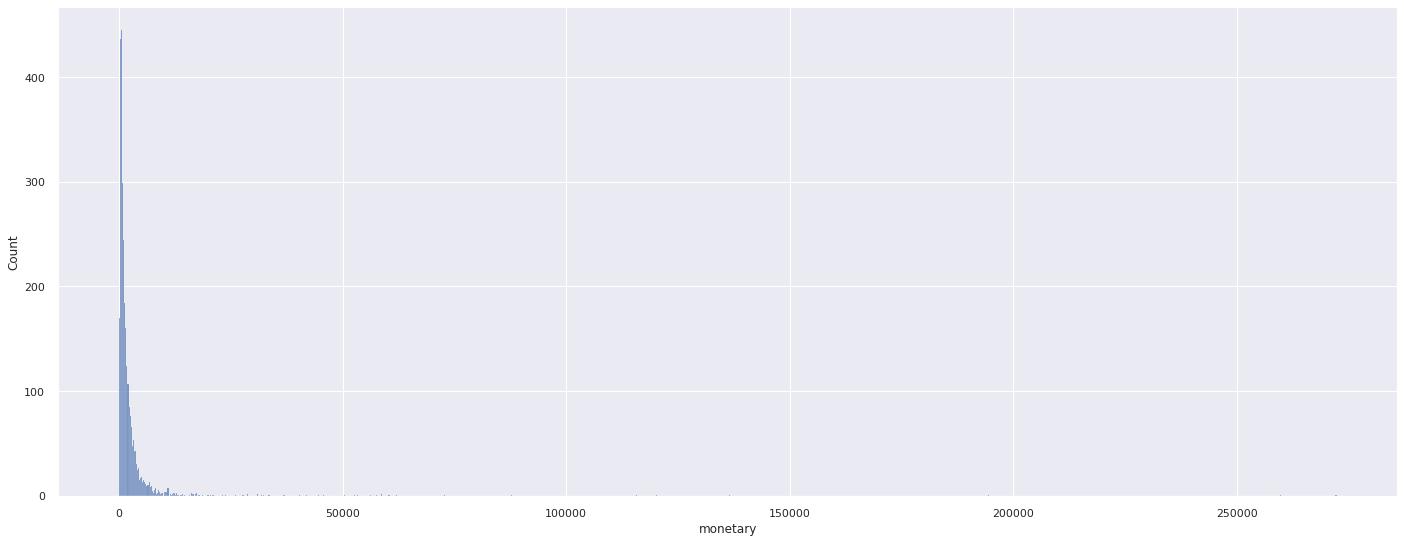

In [43]:
sns.histplot(df4['monetary']);

In [44]:
df4.sort_values('monetary', ascending=False).head(10)

,customer_id,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1015,14646,272345.66,1.00,72.00,177148.00,1905.00,142.96,7.84,0.20,288.00,2460.39,8.99
492,18102,259657.30,0.00,60.00,64124.00,431.00,602.45,14.68,0.16,0.00,1068.73,2.50
433,17450,194550.79,8.00,46.00,69993.00,337.00,577.30,12.82,0.13,952.00,1521.59,2.70
66,14911,136626.96,1.00,199.00,66368.00,5337.00,25.60,2.60,0.53,3217.00,333.51,8.37
1147,12415,120193.93,24.00,20.00,64493.00,644.00,186.64,20.87,0.06,427.00,3224.65,19.65
190,14156,115727.35,9.00,55.00,52013.00,1353.00,85.53,7.26,0.15,859.00,945.69,12.49
15,17511,87716.48,2.00,31.00,52259.00,856.00,102.47,11.59,0.08,1534.00,1685.77,12.26
12,16029,72882.09,38.00,62.00,40207.00,241.00,302.42,9.05,0.18,8004.00,648.50,0.69
953,16684,62078.12,4.00,26.00,36731.00,243.00,255.47,22.12,0.07,864.00,1412.73,3.88
8,15311,60402.22,0.00,91.00,36978.00,2326.00,25.97,4.14,0.24,474.00,406.35,6.00


### 4.1.2. qtde_invoices

In [45]:
df4.sort_values('qtde_invoices', ascending=False).head(10)

,customer_id,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
47,12748,30956.41,0.00,202.00,20068.00,4222.00,7.33,3.39,0.54,1487.00,99.35,8.20
66,14911,136626.96,1.00,199.00,66368.00,5337.00,25.60,2.60,0.53,3217.00,333.51,8.37
68,17841,40276.21,1.00,123.00,19368.00,7599.00,5.30,3.32,0.33,189.00,157.46,10.30
278,13089,58638.99,2.00,97.00,30554.00,1806.00,32.47,4.48,0.26,283.00,314.99,6.47
8,15311,60402.22,0.00,91.00,36978.00,2326.00,25.97,4.14,0.24,474.00,406.35,6.00
96,14606,11894.68,1.00,91.00,5735.00,2630.00,4.52,4.28,0.24,242.00,63.02,8.78
183,12971,10178.67,3.00,85.00,5873.00,280.00,36.35,5.35,0.23,85.00,69.09,1.08
1015,14646,272345.66,1.00,72.00,177148.00,1905.00,142.96,7.84,0.20,288.00,2460.39,8.99
19,13408,27998.09,1.00,62.00,15847.00,469.00,59.70,7.29,0.17,104.00,255.60,3.66
12,16029,72882.09,38.00,62.00,40207.00,241.00,302.42,9.05,0.18,8004.00,648.50,0.69


### 4.1.3. qtde_items

In [46]:
df4.sort_values('qtde_items', ascending=False).head(10)

,customer_id,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1015,14646,272345.66,1.00,72.00,177148.00,1905.00,142.96,7.84,0.20,288.00,2460.39,8.99
433,17450,194550.79,8.00,46.00,69993.00,337.00,577.30,12.82,0.13,952.00,1521.59,2.70
66,14911,136626.96,1.00,199.00,66368.00,5337.00,25.60,2.60,0.53,3217.00,333.51,8.37
1147,12415,120193.93,24.00,20.00,64493.00,644.00,186.64,20.87,0.06,427.00,3224.65,19.65
492,18102,259657.30,0.00,60.00,64124.00,431.00,602.45,14.68,0.16,0.00,1068.73,2.50
15,17511,87716.48,2.00,31.00,52259.00,856.00,102.47,11.59,0.08,1534.00,1685.77,12.26
190,14156,115727.35,9.00,55.00,52013.00,1353.00,85.53,7.26,0.15,859.00,945.69,12.49
12,16029,72882.09,38.00,62.00,40207.00,241.00,302.42,9.05,0.18,8004.00,648.50,0.69
36,13694,58817.24,3.00,49.00,39984.00,461.00,127.59,10.57,0.13,1264.00,816.00,5.69
8,15311,60402.22,0.00,91.00,36978.00,2326.00,25.97,4.14,0.24,474.00,406.35,6.00


In [47]:
# variation rate from 2 to 1 placed in relation to the quantity of items

# (( vf - vi ) / vi) * 100
vr = ((177148 - 69993) / 69993) * 100
print('NOTE: variation rate from 2 to 1 placed in relation to the quantity of items is: {}%'.format(round(vr, 0)))

NOTE: variation rate from 2 to 1 placed in relation to the quantity of items is: 153.0%


### 4.1.4. qtde_products

In [48]:
df4.sort_values('qtde_products', ascending=False).head(15)

,customer_id,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
68,17841,40276.21,1.00,123.00,19368.00,7599.00,5.30,3.32,0.33,189.00,157.46,10.30
66,14911,136626.96,1.00,199.00,66368.00,5337.00,25.60,2.60,0.53,3217.00,333.51,8.37
4394,14096,53258.43,4.00,17.00,16336.00,5095.00,10.45,6.06,0.17,0.00,960.94,65.76
47,12748,30956.41,0.00,202.00,20068.00,4222.00,7.33,3.39,0.54,1487.00,99.35,8.20
96,14606,11894.68,1.00,91.00,5735.00,2630.00,4.52,4.28,0.24,242.00,63.02,8.78
8,15311,60402.22,0.00,91.00,36978.00,2326.00,25.97,4.14,0.24,474.00,406.35,6.00
1015,14646,272345.66,1.00,72.00,177148.00,1905.00,142.96,7.84,0.20,288.00,2460.39,8.99
278,13089,58638.99,2.00,97.00,30554.00,1806.00,32.47,4.48,0.26,283.00,314.99,6.47
1395,13263,7096.77,1.00,34.00,3644.00,1577.00,4.50,10.12,0.10,0.00,107.18,11.85
370,15039,19836.20,9.00,47.00,8969.00,1487.00,13.34,8.76,0.13,18.00,190.83,8.43


### 4.1.5. frequency

In [49]:
df4.sort_values('frequency', ascending=False).head(15)

,customer_id,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,50.97,0.62
5563,18139,8438.34,17.00,6.00,5557.00,159.00,53.07,1.00,3.00,0.00,926.17,5.83
803,15468,467.51,51.00,2.00,155.00,24.00,19.48,108.33,2.00,5.00,77.50,12.00
3510,17900,112.20,190.00,2.00,73.00,6.00,18.70,26.00,2.00,72.00,36.50,2.00
4171,13388,677.10,131.00,2.00,282.00,35.00,19.35,10.00,2.00,1.00,141.00,17.50
1722,12410,533.33,308.00,2.00,207.00,25.00,21.33,7.00,2.00,2.00,103.50,12.50
82,16048,256.44,373.00,2.00,144.00,8.00,32.05,288.00,2.00,1.00,72.00,4.00
5682,15060,281.67,8.00,3.00,187.00,100.00,2.82,1.00,1.50,0.00,62.33,22.67
4901,17509,6115.14,57.00,8.00,3534.00,366.00,16.71,3.00,1.14,4.00,441.75,9.38
2840,12982,374.18,242.00,1.00,244.00,26.00,14.39,3.00,1.00,9.00,244.00,26.00


## 4.2. Bivariate Analysis

In [50]:
# sns.pairplot(df5);

## 4.3. Space Study

In [90]:
df43 = df4.drop(columns=['customer_id']).copy()

In [91]:
mms = pp.MinMaxScaler()

df43['monetary'] = mms.fit_transform( df43[['monetary']].values )
df43['recency_days'] = mms.fit_transform( df43[['recency_days']].values )
df43['qtde_invoices'] = mms.fit_transform( df43[['qtde_invoices']].values )
df43['qtde_items'] = mms.fit_transform( df43[['qtde_items']].values )
df43['qtde_products'] = mms.fit_transform( df43[['qtde_products']].values )
df43['avg_ticket'] = mms.fit_transform( df43[['avg_ticket']].values )
df43['avg_recency_days'] = mms.fit_transform( df43[['avg_recency_days']].values )
df43['frequency'] = mms.fit_transform( df43[['frequency']].values )
df43['qtde_returns'] = mms.fit_transform( df43[['qtde_returns']].values )
df43['avg_basket_size'] = mms.fit_transform( df43[['avg_basket_size']].values )
df43['avg_unique_basket_size'] = mms.fit_transform( df43[['avg_unique_basket_size']].values )

X = df43.copy()

### 4.3.1. PCA

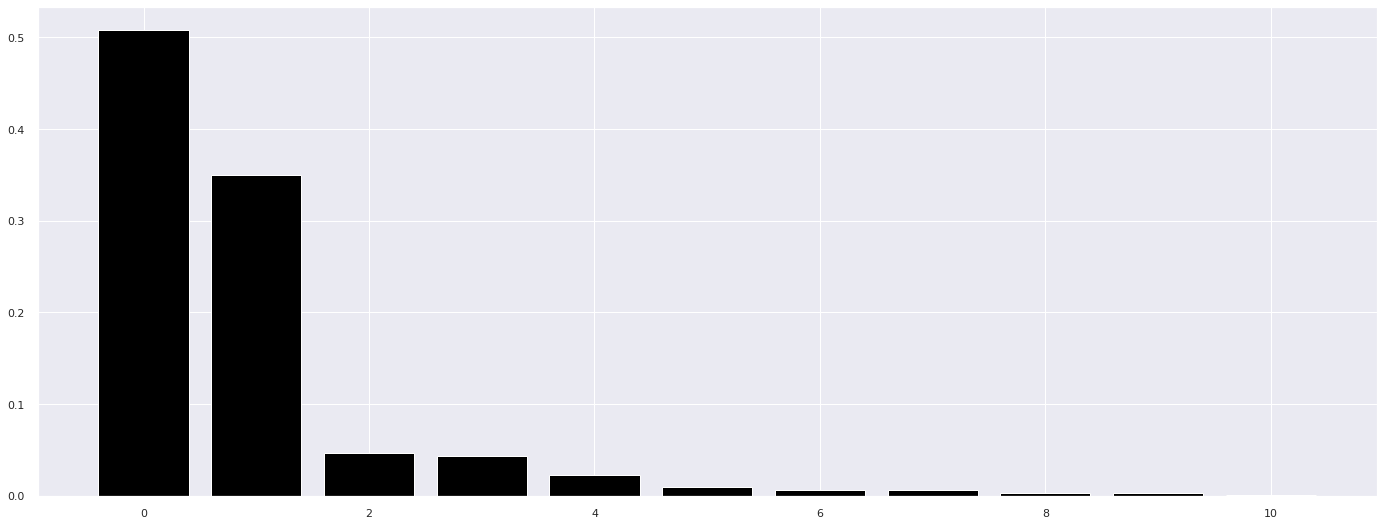

In [92]:
pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform( X )

features = range(pca.n_components_)

# plot PCA 
plt.bar( features, pca.explained_variance_ratio_, color='black' );

In [93]:
df_pca = pd.DataFrame(principal_components)

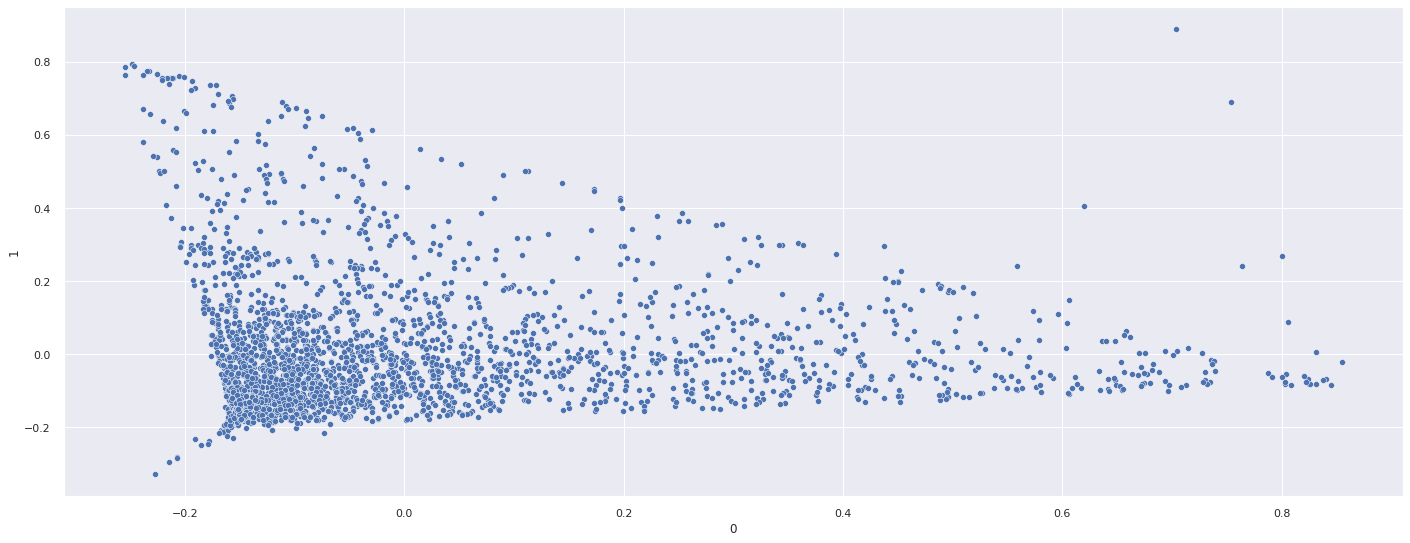

In [95]:
sns.scatterplot( x=0, y=1, data=df_pca );

### 4.3.2. UMAP

In [100]:
df_umap = pd.DataFrame()

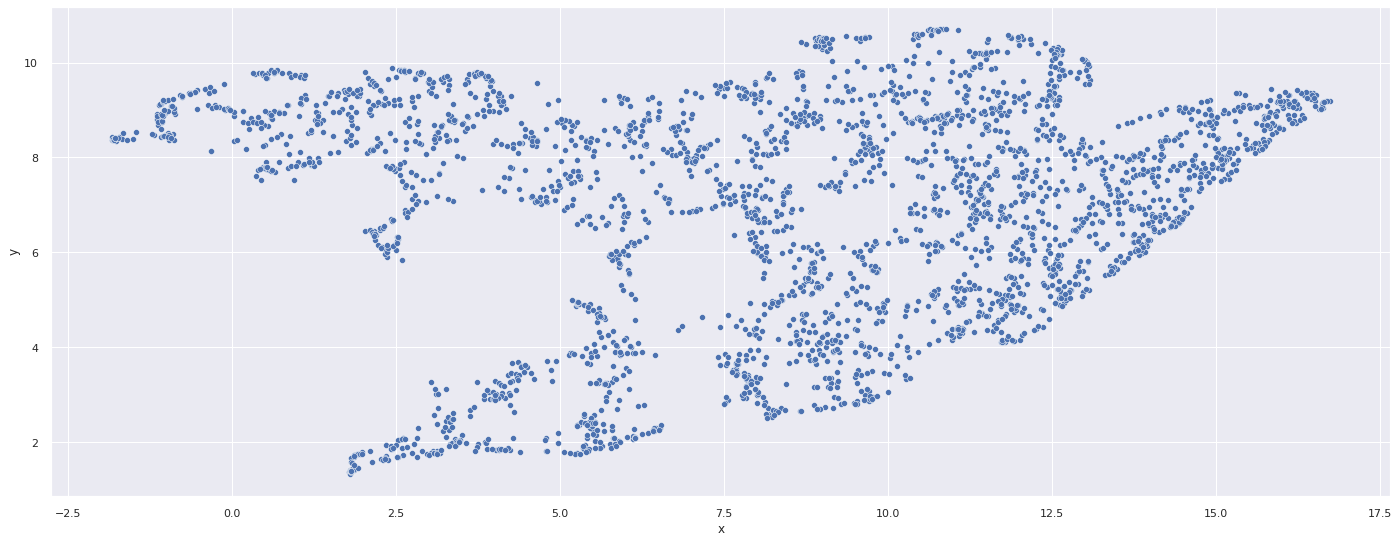

In [103]:
reducer = UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap['x'] = embedding[:, 0]
df_umap['y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='x', y='y', data=df_umap);

### 4.3.3. t-SNE

In [107]:
df_tsne = pd.DataFrame()

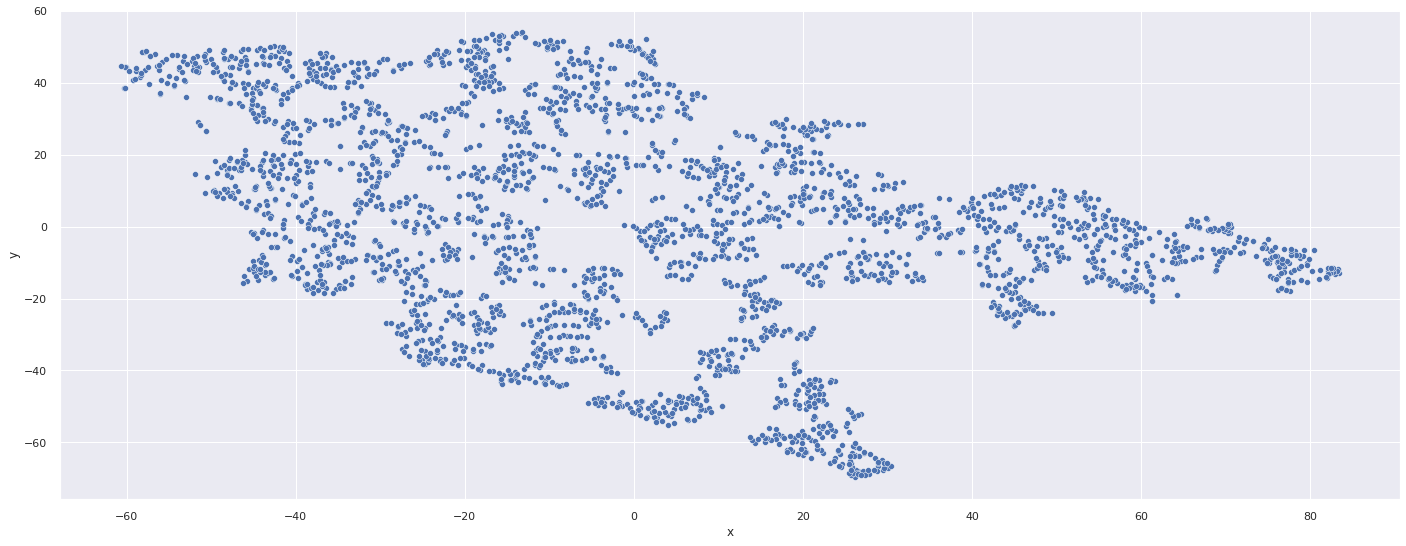

In [109]:
reducer = TSNE(n_components=2, random_state=42)
embedding = reducer.fit_transform( X )

# embedding
df_tsne['x'] = embedding[:, 0]
df_tsne['y'] = embedding[:, 1]

# plot t-SNE
sns.scatterplot( x='x', y='y', data=df_tsne);

### 4.3.4. Tree-Based Embbedding

In [112]:
X = df4.drop(columns=['customer_id', 'monetary'])
y = df4['monetary']

# model training
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training definition
rf_model.fit( X, y)

RandomForestRegressor(random_state=42)

In [113]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [114]:
X.shape, df_leaf.shape

((2956, 10), (2956, 100))

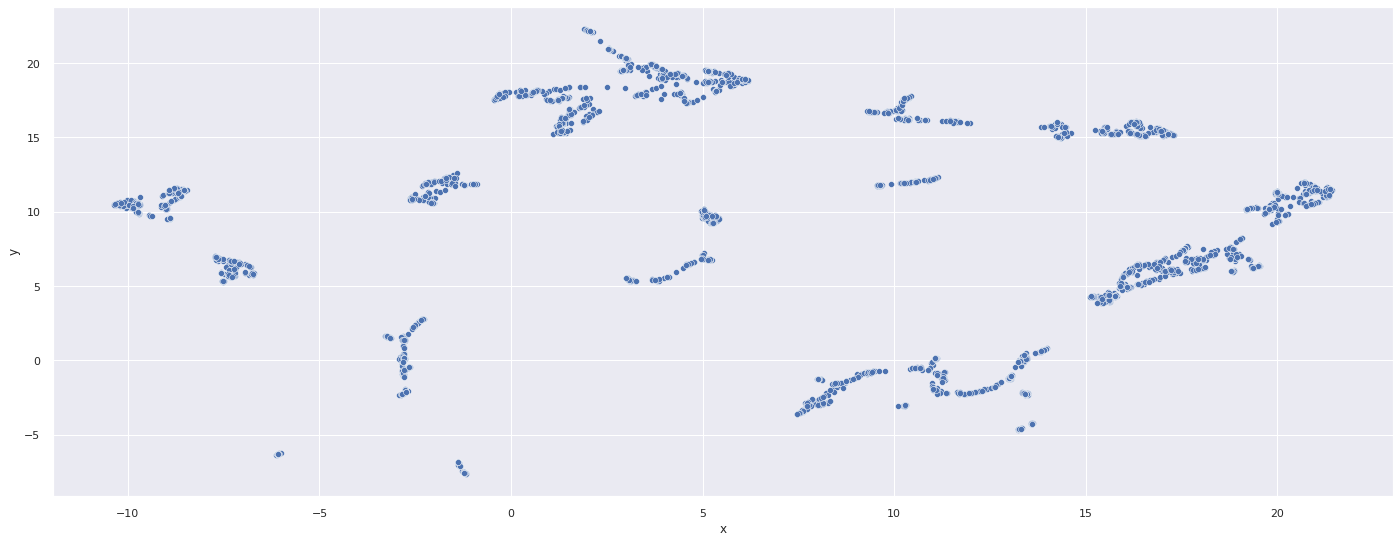

In [118]:
df_leaf_umap = pd.DataFrame()

# reduzer dimensionality
reducer = UMAP(random_state=42)
embedding = reducer.fit_transform( df_leaf )

# embedding
df_leaf_umap['x'] = embedding[:, 0]
df_leaf_umap['y'] = embedding[:, 1]

# plot 
sns.scatterplot( x='x', y='y', data=df_leaf_umap );

# 5.0. Data Preparation 

In [ ]:
df5 = df4.copy()

In [ ]:
cols = ['monetary', 'recency_days', 'qtde_invoices',
        'qtde_items', 'qtde_products', 'avg_ticket', 'avg_recency_days',
        'frequency', 'qtde_returns', 'avg_basket_size',
        'avg_unique_basket_size']

plt.title('Before the scale', size=30)
for col in cols:
    sns.kdeplot(df5[col], label=col);
    plt.legend();

In [ ]:
ss = pp.StandardScaler()

df5['monetary'] = ss.fit_transform(df5[['monetary']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['qtde_invoices'] = ss.fit_transform(df5[['qtde_invoices']])
df5['qtde_items'] = ss.fit_transform(df5[['qtde_items']])
df5['qtde_products'] = ss.fit_transform(df5[['qtde_products']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = ss.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['qtde_returns'] = ss.fit_transform(df5[['qtde_returns']])
df5['avg_basket_size'] = ss.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']])

In [ ]:
cols = ['monetary', 'recency_days', 'qtde_invoices',
        'qtde_items', 'qtde_products', 'avg_ticket', 'avg_recency_days',
        'frequency', 'qtde_returns', 'avg_basket_size',
        'avg_unique_basket_size']
plt.title('After the scale', size=30)
for col in cols:
    sns.kdeplot(df5[col], label=col);
    plt.legend();

# 6.0. Feature Selection

In [ ]:
df6 = df5.copy()

# 7.0. Hyperpameter Fine Tuning

In [135]:
# X = df6.drop(columns=['customer_id'])
X = df_leaf_umap.copy()

X.head()

,x,y
0,-8.90,9.54
1,-2.22,11.85
2,-2.90,0.23
3,3.06,5.51
4,12.70,-1.62


In [136]:
clusters = [2,3,4,5,6,7]

## KMeans

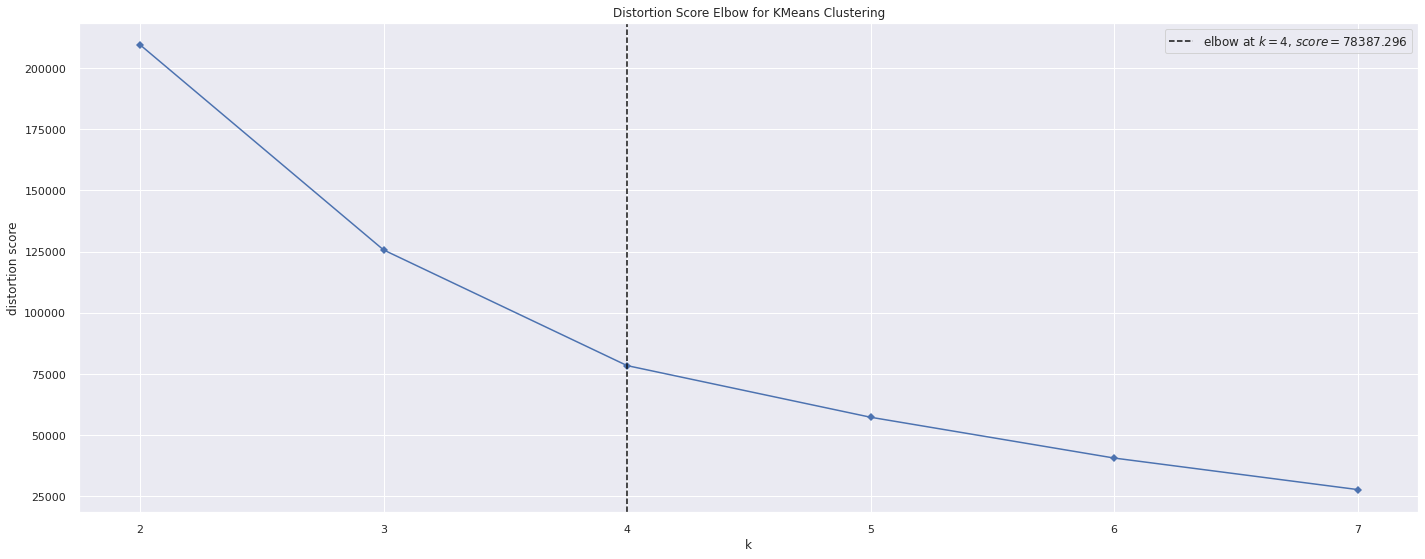

In [137]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=clusters, timings=False)
kmeans.fit( X )
kmeans.show();

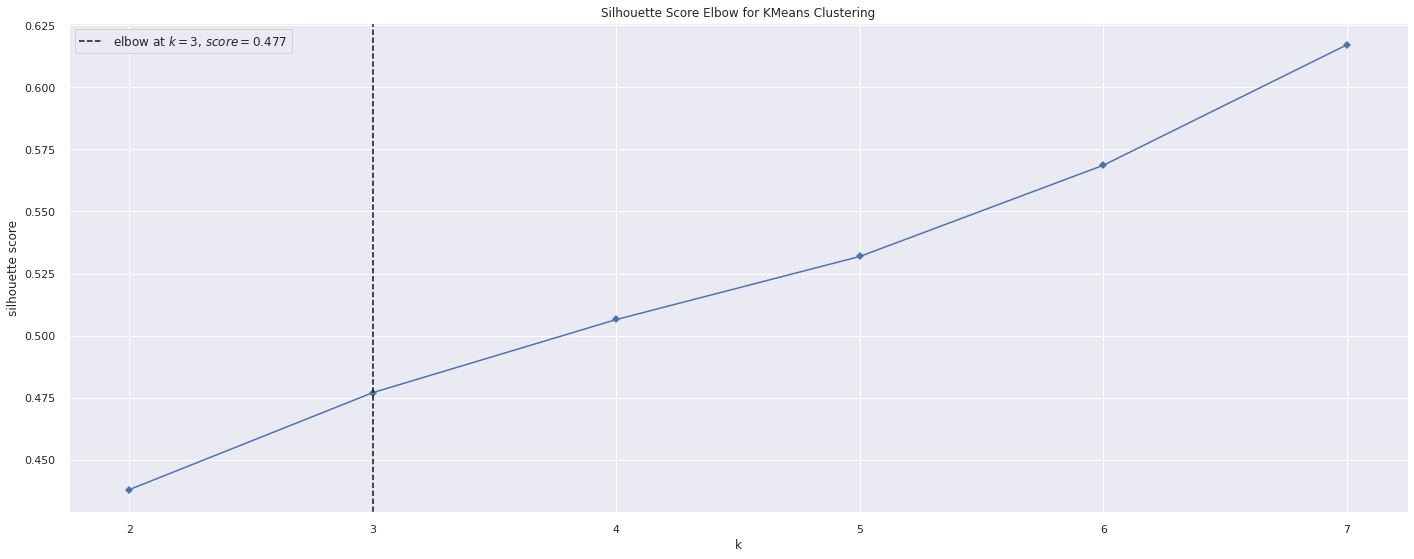

In [138]:
km = KElbowVisualizer(cluster.KMeans(), k=clusters, metric='silhouette', timings=False)
km.fit( X )
km.show();

## 7.1. Silhouette Analysis

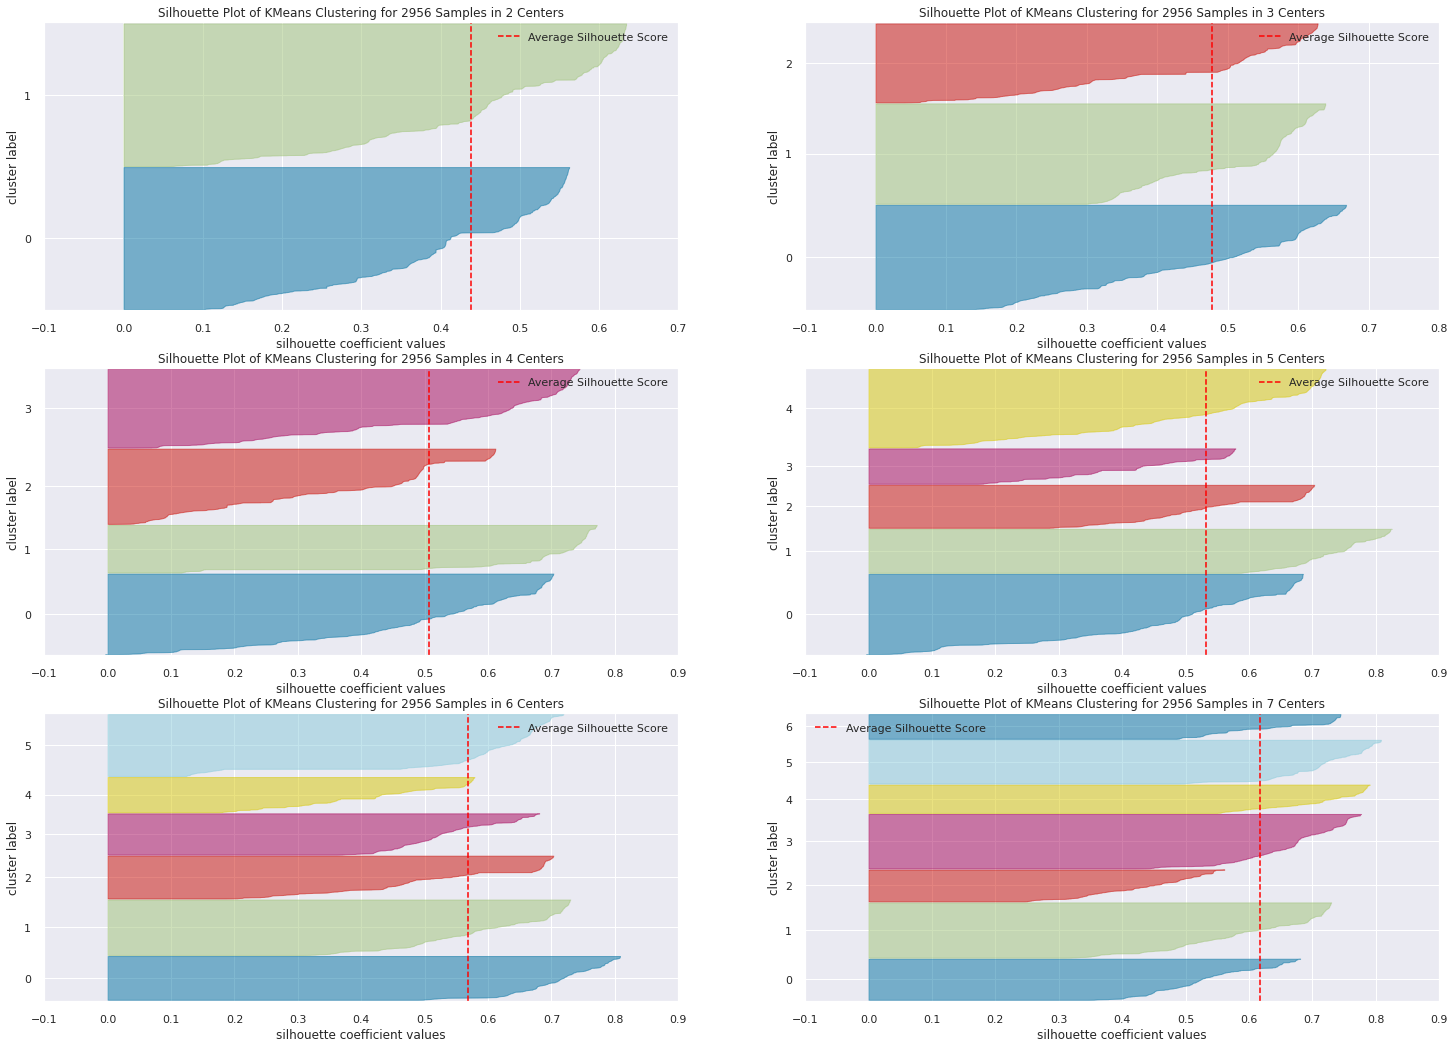

In [139]:
fig, ax = plt.subplots(3,2, figsize=(25, 18))

for k in clusters:
    km = cluster.KMeans(n_clusters=k, init='random', n_init=10, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize();

# 8.0. Model Training

## 8.1. K-Means

In [149]:
# model definition
k = 5
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [150]:
print('WSS value: {}'.format( kmeans.inertia_ ))
print('SS value: {}'.format( metrics.silhouette_score(X, labels, metric='euclidean') ))

WSS value: 57269.97265625
SS value: 0.5318971872329712


# 9.0. Cluster Analysis

In [151]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,customer_id,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,50.97,0.62,1
1,13047,3232.59,56.00,9.00,1390.00,171.00,18.90,27.25,0.03,35.00,154.44,11.67,1
2,12583,6495.30,2.00,15.00,3796.00,221.00,29.39,23.19,0.04,50.00,253.07,7.13,3
3,13748,938.89,95.00,5.00,415.00,27.00,34.77,92.67,0.02,0.00,83.00,4.60,3
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,0.33,4


## 9.1. Visualization Inspection

In [152]:
df_viz = df9.drop(columns='customer_id')

### 9.1.1. Silhouette Analysis

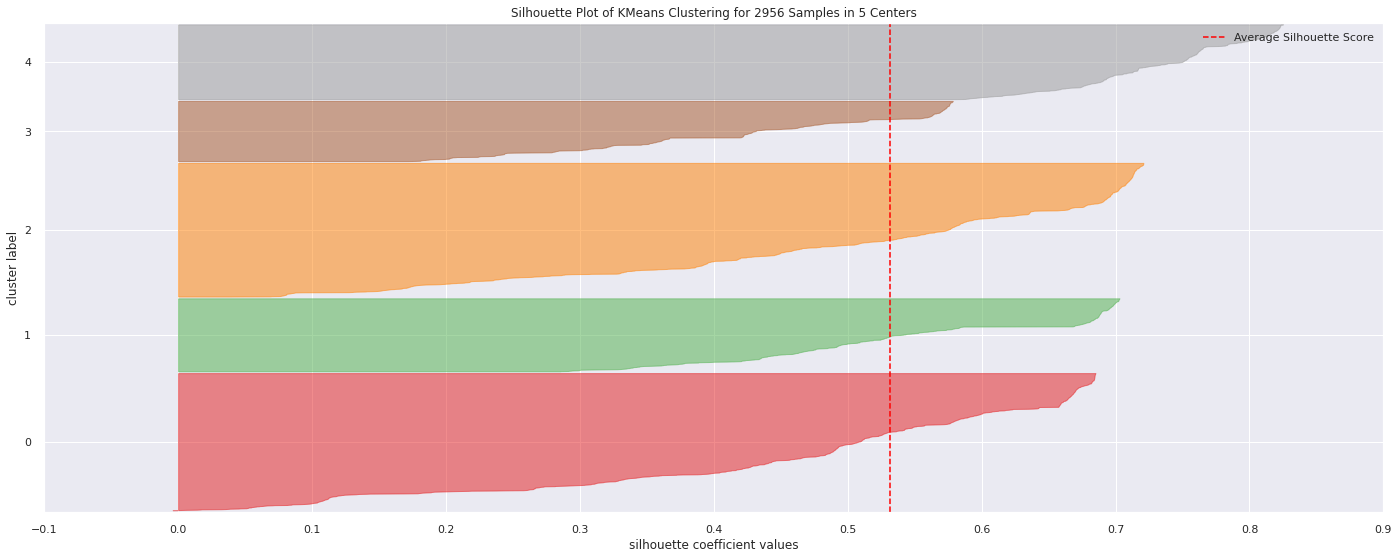

In [153]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit( X )
visualizer.finalize();

### 9.1.2 2d plot

In [154]:
# sns.pairplot(df_viz, hue='cluster');

### 9.1.3. UMAP

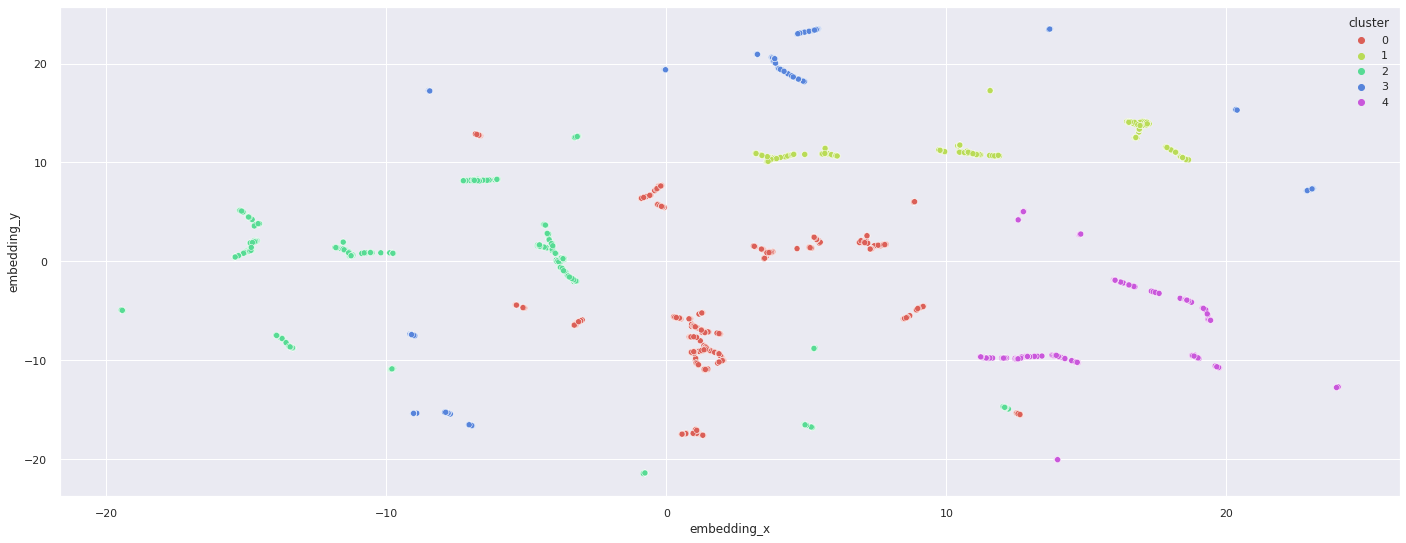

In [155]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform( X )

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz );

## 9.2. Cluster Profile

In [156]:
df9.head()

,customer_id,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,50.97,0.62,1
1,13047,3232.59,56.00,9.00,1390.00,171.00,18.90,27.25,0.03,35.00,154.44,11.67,1
2,12583,6495.30,2.00,15.00,3796.00,221.00,29.39,23.19,0.04,50.00,253.07,7.13,3
3,13748,938.89,95.00,5.00,415.00,27.00,34.77,92.67,0.02,0.00,83.00,4.60,3
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,0.33,4


In [157]:
# cluster - qt_users - per_user
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'qt_users'})
df_cluster['per_user'] = 100 * (df_cluster['qt_users'] / df_cluster['qt_users'].sum())


# monetary
monetary = df9[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, monetary, how='left', on='cluster')


# recency_days
recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, recency_days, how='left', on='cluster')

# qtde_invoices
qtde_invoices = df9[['qtde_invoices', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, qtde_invoices, how='left', on='cluster')

# qtde_products
qtde_products = df9[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, qtde_products, how='left', on='cluster')


# qtde_items
qtde_items = df9[['qtde_items', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, qtde_items, how='left', on='cluster')

# frequency
frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, frequency, how='left', on='cluster')

# qtde_returns
qtde_returns = df9[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, qtde_returns, how='left', on='cluster')



df_cluster.sort_values('monetary', ascending=False)

,cluster,qt_users,per_user,monetary,recency_days,qtde_invoices,qtde_products,qtde_items,frequency,qtde_returns
3,3,372,12.58,11671.53,26.13,16.84,343.41,6057.82,0.07,161.65
1,1,451,15.26,3263.37,35.58,7.43,185.55,1805.84,0.08,30.20
2,2,825,27.91,1585.12,47.65,5.03,103.34,827.21,0.05,16.18
0,0,846,28.62,657.39,84.30,2.56,49.56,330.27,0.12,7.39
4,4,462,15.63,308.21,115.95,2.12,21.65,116.21,0.29,4.76


# 10.0. Deploy to Product